# An R example: ashr benchmark

This is a more advanced application of DSC with R scripts. We demonstrate in this tutorial features of DSC including:

*  Inline code as parameters
*  `@ALIAS` decorator
*  R library installation and version check
*  Use `dscrutils` to query results limited to given conditions

## DSC Problem
The DSC problem is based on the ASH example of DSCR ([R Markdown version](https://github.com/stephens999/dscr/blob/master/vignettes/dsc_shrink.rmd) and [HTML version](dscr_dsc_shrink.html)). Material to run this tutorial can be found in [DSC vignettes repo](https://github.com/stephenslab/dsc/tree/master/vignettes/ash). Description below is copied from the DSCR vignette:

> To illustrate we consider the problem of shrinkage, which is tackled by the `ashr` package at [http://www.github.com/stephens999/ashr](http://www.github.com/stephens999/ashr). The input to this DSC is a set of estimates $\hat\beta$,  with associated standard errors $s$. These values are estimates of actual (true) values for $\beta$, so the meta-data in this case are the true values of beta. Methods must take $\hat\beta$ and $s$ as input, and provide as output "shrunk" estimates for $\beta$ (so output is a list with one element, called `beta_est`, which is a vector of estimates for beta). The score function then scores methods on their RMSE comparing `beta_est` with beta.

> First define a datamaker which simulates true values of $\beta$ from a user-specified normal mixture, where one of the components is a point mass at 0 of mass $\pi_0$, which is a user-specified parameter. It then simulates $\hat\beta \sim N(\beta_j,s_j)$ (where $s_j$ is again user-specified). It returns the true $\beta$ values and true $\pi_0$ value as meta-data, and the estimates $\hat\beta$ and $s$ as input-data.


> Now define a [method wrapper](https://github.com/stephenslab/dsc/blob/master/vignettes/ash/bin/runash.R) for the `ash` function from the `ashr` package. Notice that this wrapper does not return output in the required format - it simply returns the entire ash output.

> Finally add a generic (can be used to deal with both $\pi$ and $\beta$) [score function](https://github.com/stephenslab/dsc/blob/master/vignettes/ash/bin/score.R) to evaluate estimates by `ash`.

## DSC Specification
The problem is fully specified in DSC syntax below, following the structure of the original `DSCR` implementation:

```
#!/usr/bin/env dsc
simulate: datamaker.R
    # module input and variables
    mixcompdist: normalmix
    g: (c(2/3,1/3),c(0,0),c(1,2)),
       (rep(1/7,7),c(-1.5,-1,-0.5,0,0.5,1,1.5),rep(0.5,7)),
       (c(1/4,1/4,1/3,1/6),c(-2,-1,0,1),c(2,1.5,1,1))
    min_pi0: 0
    max_pi0: 1
    nsamp: 1000
    betahatsd: 1
    # module decoration
    @ALIAS: args = List()
    # module output
    $data: data
    $true_beta: data$meta$beta
    $true_pi0: data$meta$pi0

shrink: runash.R
    # module input and variables
    input: $data
    mixcompdist: "normal", "halfuniform"
    # module output
    $ash_data: ash_data
    $beta_est: ashr::get_pm(ash_data)
    $pi0_est: ashr::get_pi0(ash_data)

score_beta: score.R
    # module input and variables
    est: $true_beta
    truth: $beta_est
    # module output aka pipeline variable
    $mse: result

score_pi0: score.R
    # module input and variables
    est: $pi0_est
    truth: $true_pi0
    # module output
    $mse: result

DSC:
    # module ensembles
    define:
      score: score_beta, score_pi0
    # pipelines
    run: simulate * shrink * score
    # runtime environments
    R_libs: ashr@stephens999 (2.2.7+)
    exec_path: bin
    output: dsc_result
```

It is suggested that you check out the corresponding R codes for modules [`simulate`](https://github.com/stephenslab/dsc/blob/master/vignettes/ash/bin/datamaker.R), [`shrink`](https://github.com/stephenslab/dsc/blob/master/vignettes/ash/bin/runash.R) and the [score function](https://github.com/stephenslab/dsc/blob/master/vignettes/ash/bin/score.R) to figure out how DSC communicates with your R scripts.

Here we will walk through all modules to highlight important syntactical elements.

### Module `simulate`

#### Un-quoted string as parameters and output values

The parameter `g` has three candidate values, all of which are un-quoted string to be plugged to script as is. In other words, DSC will interpret each as, eg, `g <- list(c(2/3,1/3),c(0,0),c(1,2))` so that `g` will be assigned **at runtime** the output of R codes as specified for use with `datamaker.R`. Similarly, `mixcompdist: normalmix` will be interpreted as `mixcompdist <- normalmix` -- this statement is valid as long as `datamaker.R` has loaded `ashr` library, because `normalmix` is function from `ashr` library.

#### Decorator `@ALIAS` for R list
Inside `datamaker.R` the input for the core function is a single parameter of an R [list](http://www.r-tutor.com/r-introduction/list) containing all parameters specified in this module. The decorator `@ALIAS` uses a special DSC operation `List()` to consolidate these parameters into an R list `args` which corresponds to the input parameter in `datamaker.R`.

### Module `shrink` 
Here notice the output variable are also provided at runtime: DSC allows output variables to directly accept pieces of codes that can provide the desired output. In this case, `get_pi0` function from `ashr` package will get us what we need.

### Module `beta_score` & `pi0_score`
These modules uses the same module executable `score.R` but on different input data. Due to differences in variable names it makes sense to configure them in separate blocks. However an alternative style that configures them in the same block is:

```
score_beta, score_pi0: score.R
    @score_beta:
        est: $true_beta
        truth: $beta_est
        $mse_beta: result
    @score_pi0:
        est: $pi0_est
        truth: $true_pi0
        $mse_pi: result        
```

Here `@*` are module specific variable decorations that configures input and output such that different modules can be allowed in the same block. 

Notice that different from the [DSCR ASH example](https://github.com/stephens999/dscr/blob/master/vignettes/dsc_shrink.rmd) the output score is an "atomic" value (a float number). If the outcome object `result` is not such a simple object, for example it returns an R list, then you may want to code it to only extract the information you need so that they'll be readily extractable in the benchmark query process -- the query process can only extract [atomic types](https://stat.ethz.ch/R-manual/R-devel/library/base/html/is.recursive.html). To do so, you can write something like, e.g., `$mse_pi: score_output$mse`.

### `DSC` section for benchmark configuration
As has been discussed in previous tutorials, `DSC` sections defines module / pipeline ensembles and a benchmark. This DSC executes essentially two pipelines (one ending with `score_beta` another with `score_pi0`). The `R_libs` property specifies the R package required by the DSC. It is formatted as a github package (`pkg@repo`) and the minimal version requirement is `2.0.0`. DSC will check first if the package is available and up-to-date, and install it if necessary. It will then check its version and quit on error if it does not satisfy the requirement. **For safety concerns, DSC does not attempt to upgrade/downgrade a package in cases of version mismatch.**

## Execution logic
This diagram (generated by `dot` command using execution graph of this DSC) shows the logic of the benchmark:

![ash.png](ash.png)

## Run DSC

We now run this DSC with 10 replicates:

In [1]:
%cd ~/GIT/dsc/vignettes/ash

/home/gaow/GIT/dsc/vignettes/ash

In [2]:
./settings.dsc --replicate 10

INFO: DSC script exported to dsc_result.html
INFO: Constructing DSC from ./settings.dsc ...
INFO: Building execution graph & running DSC ...
DSC: 100%|████████████████████████████████████████| 5/5 [02:42<00:00, 30.25s/it]
INFO: Building DSC database ...
INFO: DSC complete!
INFO: Elapsed time 165.376 seconds.


## Benchmark evaluation

### Extract result of interest

The [DSCR ASH example](https://github.com/stephens999/dscr/blob/master/vignettes/dsc_shrink.rmd) has names to various simulation settings and methods. Here we use `dscrutils` to reproduce the DSCR example. It is similar to what we have done in the [DSC Introduction example](../tutorials/Intro_DSC.html), but we will demonstrate the use of `condition` argument, to create 3 data-sets:

In [3]:
setwd('~/GIT/dsc/vignettes/ash')
dsc_dir = 'dsc_result'

In [4]:
An = dscrutils::dscquery(dsc_dir, targets = c("simulate.true_pi0",
                                              "shrink.mixcompdist",
                                              "shrink.beta_est",
                                              "shrink.pi0_est",
                                              "score.mse"),
                         condition = "simulate.g = 'list(c(2/3,1/3),c(0,0),c(1,2))'")

Loading dsc-query output from CSV file.
Reading DSC outputs:
 - simulate.true_pi0: extracted atomic values
 - shrink.beta_est: vectors not extracted (set max.extract.vector = 1000 to extract)
 - shrink.pi0_est: extracted atomic values
 - score.mse: extracted atomic values


In [5]:
Bn = dscrutils::dscquery(dsc_dir, targets = c("simulate.true_pi0",
                                              "shrink.mixcompdist",
                                              "shrink.beta_est",
                                              "shrink.pi0_est", 
                                              "score.mse"),
                         condition = "simulate.g = 'list(rep(1/7,7),c(-1.5,-1,-0.5,0,0.5,1,1.5),rep(0.5,7))'")

Loading dsc-query output from CSV file.
Reading DSC outputs:
 - simulate.true_pi0: extracted atomic values
 - shrink.beta_est: vectors not extracted (set max.extract.vector = 1000 to extract)
 - shrink.pi0_est: extracted atomic values
 - score.mse: extracted atomic values


In [6]:
Cn = dscrutils::dscquery(dsc_dir, targets = c("simulate.true_pi0",
                                              "shrink.mixcompdist",
                                              "shrink.beta_est",
                                              "shrink.pi0_est", 
                                              "score.mse"),
                         condition = "simulate.g = 'list(c(1/4,1/4,1/3,1/6),c(-2,-1,0,1),c(2,1.5,1,1))'")

Loading dsc-query output from CSV file.
Reading DSC outputs:
 - simulate.true_pi0: extracted atomic values
 - shrink.beta_est: vectors not extracted (set max.extract.vector = 1000 to extract)
 - shrink.pi0_est: extracted atomic values
 - score.mse: extracted atomic values


To view one of the resulting data frame:

In [7]:
head(An)

DSC,simulate.true_pi0,shrink.beta_est,shrink.mixcompdist,shrink.pi0_est,score,score.mse
1,0.2655087,shrink/simulate_1_shrink_1,normal,0.4792830,score_beta,0.7336363
1,0.2655087,shrink/simulate_1_shrink_1,normal,0.4792830,score_pi0,0.2137744
1,0.2655087,shrink/simulate_1_shrink_2,halfuniform,0.6016295,score_beta,0.7401442
1,0.2655087,shrink/simulate_1_shrink_2,halfuniform,0.6016295,score_pi0,0.3361209
2,0.1848823,shrink/simulate_4_shrink_1,normal,0.4528959,score_beta,0.7968913
2,0.1848823,shrink/simulate_4_shrink_1,normal,0.4528959,score_pi0,0.2680137


### Explore results of interest

Suppose we are interested in comparing $\pi_0$ estimates under scenario `An`, for two flavors of shrink module `normal` and `halfuniform`.

In [8]:
normal = subset(An, shrink.mixcompdist == 'normal')
hu = subset(An, shrink.mixcompdist == 'halfuniform')

First, we visualize estimated vs true $\pi_0$ for two methods:

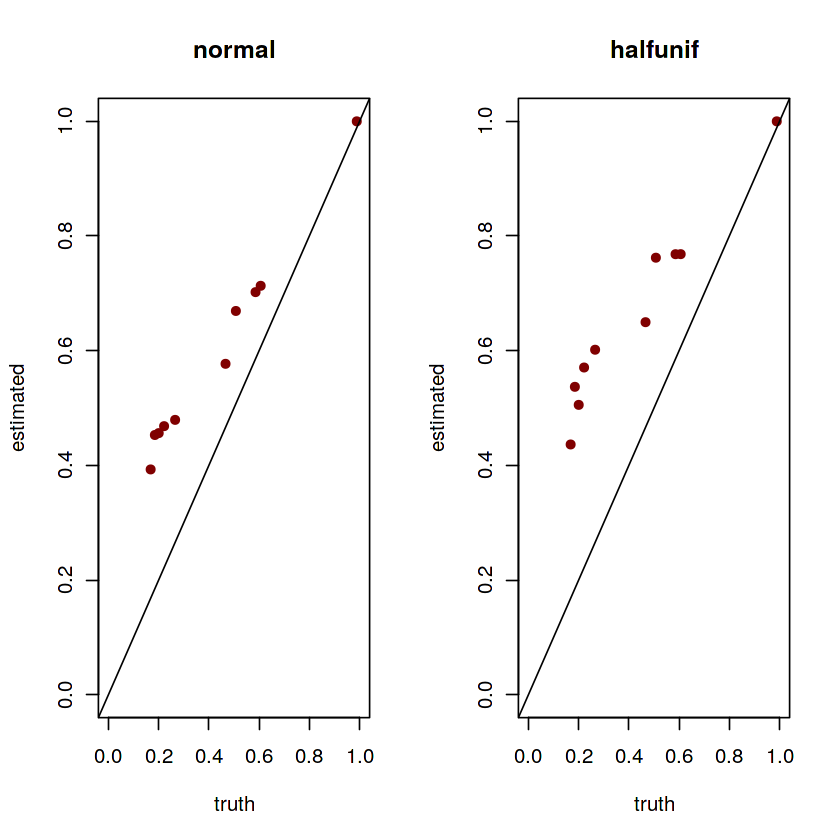

In [9]:
par(mfrow=c(1,2))
plot(subset(normal, score == 'score_pi0')$simulate.true_pi0, 
     subset(normal, score == 'score_pi0')$shrink.pi0_est, 
     xlab = 'truth', ylab = 'estimated', main = 'normal', 
     pch = 16, col = "#800000", xlim = c(0,1), ylim = c(0,1))
abline(a=0,b=1)
plot(subset(hu, score == 'score_pi0')$simulate.true_pi0, 
     subset(hu, score == 'score_pi0')$shrink.pi0_est, 
     xlab = 'truth', ylab = 'estimated', main = 'halfunif', 
     pch = 16, col = "#800000", xlim = c(0,1), ylim = c(0,1))
abline(a=0,b=1)

We then summarize the MSE scores for the two methods:

In [10]:
suppressMessages(library(plotly))
options(warn=-1)
p = plot_ly(y = subset(normal, score == 'score_pi0')$score.mse, name = 'Normal', type = "box") %>%
    add_trace(y = subset(hu, score == 'score_pi0')$score.mse, name = 'Half Uniform', type = "box")  %>% 
    layout(title = "MSE for pi_0 estimate")
htmlwidgets::saveWidget(as_widget(p), "pi0_score.html")

In [ ]:
from IPython.display import IFrame
IFrame('pi0_score.html', '100%', 400)

## Explore intermediate output

We have previously focused on benchmark "results", ie, the mean square errors. It is also possible to extract quantities of interest from any module in the benchmark. For example we want to explore relationship between "true" value and posterior estimates of $\beta$ from method `normal` and `halfnormal`. First we use `dscrutils` to extract these quantities:

In [12]:
dat2 = dscrutils::dscquery(dsc_dir,
                           targets = c("simulate.true_beta", "shrink.mixcompdist", "shrink.beta_est"),
                           condition = "simulate.g = 'list(c(2/3,1/3),c(0,0),c(1,2))'",
                           max.extract.vector = 1000)

Loading dsc-query output from CSV file.
Reading DSC outputs:
 - simulate.true_beta: extracted vector values
 - shrink.beta_est: extracted vector values


In [13]:
print(dim(dat2))

[1]   20 2002


In [14]:
head(dat2[,1:5])

DSC,simulate.true_beta.1,simulate.true_beta.2,simulate.true_beta.3,simulate.true_beta.4
1,1.841107,-0.15676431,-2.7796053,0.0000000
1,1.841107,-0.15676431,-2.7796053,0.0000000
2,0.000000,-0.08736819,-0.4296717,2.3048867
2,0.000000,-0.08736819,-0.4296717,2.3048867
3,0.000000,0.00000000,-0.3067235,-0.2249873
3,0.000000,0.00000000,-0.3067235,-0.2249873


As shown above, with `max.extract.vector = 1000` we allow for extracting vector-valued $\beta$ estimates into the outputted data frame. The resulting dataframe has 2001 columns containing both $\beta$ and its posterior estimate $\tilde{\beta}_{\text{normal}}$ and $\tilde{\beta}_{\text{halfunif}}$. We make them into separate tables. Rows in each table are replicates.

In [15]:
pattern = "simulate.true_beta"
cols = which(sapply(strsplit(names(dat2),"[.]"), function (x) paste0(x[1],'.', x[2])) == pattern)
normal0 = subset(dat2, shrink.mixcompdist == 'normal')[,cols]
hu0 = subset(dat2, shrink.mixcompdist == 'halfuniform')[,cols]                 
#
pattern = "shrink.beta_est"
cols = which(sapply(strsplit(names(dat2),"[.]"), function (x) paste0(x[1],'.', x[2])) == pattern)
normal = subset(dat2, shrink.mixcompdist == 'normal')[,cols]
hu = subset(dat2, shrink.mixcompdist == 'halfuniform')[,cols]                 

To view distribution of $\tilde{\beta}$ from one replicate:

In [16]:
p = plot_ly(x = as.numeric(normal[1,]), name = 'Normal', opacity = 0.9, type = "histogram") %>%
  add_trace(x = as.numeric(hu[1,]), name = 'Half Uniform', opacity = 0.9, type = "histogram") %>%
  layout(title = "Posterior mean distribution")
htmlwidgets::saveWidget(as_widget(p), "beta.html")

In [15]:
from IPython.display import IFrame
IFrame('beta.html', '100%', 400)

Now we compare correlation between estimate and the truth for these 2 methods:

In [17]:
normal0 = as.matrix(normal0)
normal = as.matrix(normal)
normal_cor = sapply(seq.int(dim(normal0)[1]), function(i) cor(normal0[i,], normal[i,]))

In [18]:
hu0 = as.matrix(hu0)
hu = as.matrix(hu)
hu_cor = sapply(seq.int(dim(hu0)[1]), function(i) cor(hu0[i,], hu[i,]))

In [19]:
p = plot_ly(y = normal_cor, name = 'Normal', type = "box") %>%
    add_trace(y = hu_cor, name = 'Half Uniform', type = "box")  %>% 
    layout(title = "Correlation between truth and estimates for beta")
htmlwidgets::saveWidget(as_widget(p), "corr.html")

In [18]:
from IPython.display import IFrame
IFrame('corr.html', '100%', 400)